In [6]:
import numpy as np
import galois
import hashlib
import matplotlib.pyplot as plt

---
# base functions

In [7]:
# Obtain minimal gap between adyacent values for sequence X
def get_min_gap(X):
    gap = np.inf
    q = len(X)

    for i in range(q):

        d = abs(X[(i+1) % q] - X[i])

        if d < gap:
            gap = d

    return gap


# Transform number n to base b
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]


# hamming correlation with shift 0 for sequences
# u and v with the same length (assumed)
def hamming_correlation(u,v):
    u_eq_v = u == v
    return u_eq_v.sum()

# maximal hamming correlation for sequences
# u and v with the same length (assumed)
def maxHC(u,v):

    start = 0
    if np.array_equal(u,v): start = 1

    current_maxHC = 0
    for shift in range(start, len(u)):

        hc = hamming_correlation(u, np.roll(v, shift))
        
        if hc > current_maxHC:
            current_maxHC = hc
    
    return current_maxHC


# average hamming auto correlation for a family of
# sequences with the same length (assumed)
def avg_autoHC(fam):
    _avgHC = 0
    M, L = fam.shape
    for i in range(M):
        for shift in range(1, L):
            _avgHC += hamming_correlation(fam[i], np.roll(fam[i], shift))

    return _avgHC / (M * (L-1))


# average hamming cross correlation for a family of
# sequences with the same length (assumed)
def avg_crossHC(fam):
    _avgHC = 0
    M, L = fam.shape
    for i in range(M):
        for j in range(i):
            for shift in range(L):
                _avgHC += hamming_correlation(fam[i], np.roll(fam[j], shift))

    n = M * (M-1) / 2
    return _avgHC / (L*n)


# average maximal hamming correlation for all paris of
# sequences from a single family
def avg_maxHC(fam):
    mean = 0
    s = len(fam)
    for i in range(s):
        for j in range(i+1):
            mean += maxHC(fam[i], fam[j])

    n = s * (s+1) / 2
    return mean / n


# average maximal hamming correlation for all paris of
# sequences from two families
def avg_maxHC_2fam(fam1, fam2):
    mean = 0
    s = len(fam1)
    for i in range(s):
        for j in range(s):
            mean += maxHC(fam1[i], fam2[j])
        
    n = s**2
    return mean / n

---
# 1st method (family)

Generates a family of sequences with optimal maximal hammig correlation from a single m-sequence

.

Generated sequences have length q = p^n - 1

over an alphabet A of size |A| = p^k

for any given prime number p

and integers k,n s.t. 1 <= k <= n

.


[1] Lempel, A., & Greenberger, H. (1974). Families of sequences with optimal Hamming-correlation properties. IEEE Transactions on Information Theory, 20(1), 90-94.


In [8]:
"""
maps a sequence X in P^k to a value in P_k
where P^k is the set of all words of length k over P
P is the finite field (GF) of order p, i.e. P = {0, 1, ..., p-1}
P_k is the finite field (GF) of order p^k, i.e. P_k = {0, 1, ..., p^k-1}
"""
def sigma_transform(X, p, k):

    Y = []
    q = len(X)
    for j in range(q):

        y_j = 0
        for i in range(k):
            y_j += X[(j+i) % q] * p**i

        Y.append(y_j)

    return Y


"""
Following the construction presented in [1]
given an m-sequence X of length q = p^n - 1 over GF(p)
where p is a prime number
then for each k s.t. 1 <= k <= n, the set F of p^k
sequences is an optimal family

a variation of the sigma transform is used
"""
def optimal_family(X, p, k):

    family = []
    q = len(X)
    for v in range(p**k):

        z = numberToBase(v, p)
        while len(z) < k:
            z.insert(0,0)
        z.reverse()

        Y = []
        for j in range(q):

            y_j = 0
            for i in range(k):
                y_j += ( ( X[ (j+i) % q] + z[i]) % p ) * p**i

            Y.append(y_j)

        family.append(Y)
        #print(f"Y{v} = ", Y)

    return np.array(family)

In [29]:
# test from [1]
# n = 3, then q = len(X) = p^n - 1 = 3^3 - 1 = 26
X = [0,0,1,1,1,0,2,1,1,2,1,0,1,0,0,2,2,2,0,1,2,2,1,2,0,2]
testfam = optimal_family(X, 3, 2)

### test for lora m = 2**8 = 256 

In [30]:
c = galois.primitive_poly(2, 8)
lfsr = galois.GLFSR(c.reverse())

In [31]:
p = 2
k = 8
n = 8
q = p**n - 1

x1 = lfsr.step(q)
x2 = lfsr.step(q)

fam1 = optimal_family(np.array(x1), p, k)
fam2 = optimal_family(np.array(x2), p, k)

In [32]:
avg_maxHC(fam1)

0.9922178988326849

### test for lora m = 2**5 = 32 frequencies

In [85]:
c = galois.primitive_poly(2, 5)
lfsr = galois.GLFSR(c.reverse())

c

Poly(x^5 + x^2 + 1, GF(2))

In [86]:
p = 2
k = 5
n = 5
q = p**n - 1

x1 = lfsr.step(q)

method1_fam = optimal_family(np.array(x1), p, k)
method1_fam = method1_fam *8

In [87]:
method1_fam.shape

(32, 31)

In [88]:
avg_maxHC(method1_fam)

0.9393939393939394

In [89]:
avg_autoHC(method1_fam)

0.0

In [90]:
avg_crossHC(method1_fam)

0.967741935483871

---
# 2nd method (sequence)

Generates a wide gap sequence with minimum gap e and optimal maximal hamming autocorrelation

.

let X be a WGFHS of length q

over alphabet A of size |A| = l

with minimum gap e

and maximal hamming autocorrelation h

then X is defined by the parameters (q, l, h, e)
.




In [9]:
"""
let l, d s.t. 1 < d < l/2
& gcd(l, d) = gcd(l, d+1) = 1

generate an optimal WGFHS with parameters (2*l, l, 2, d-1)
"""
def get_2l_sequence(l, d):
    s = []
    t = []

    for i in range(l):
        s.append( (i*d) % l )
        t.append( (i*(d+1) + 1) % l )

    return np.array(s + t)


"""
let l, d s.t. 1 < d < (l-1)/2
& gcd(l, d) = gcd(l, d+1) = gcd(l, d+2) = 1

generate an optimal WGFHS with parameters (3*l, l, 3, d-1)
"""
def get_3l_sequence(l, d):
    s = []
    t = []
    u = []

    for i in range(l):
        s.append( (i*d) % l )
        t.append( (i*(d+1) + 1) % l )
        u.append( (i*(d+2) + 2) % l )

    return np.array(s + t + u)


# greatest common division
def gcd(a, b):
    if(b == 0): return abs(a)
    else: return gcd(b, a % b)


#### 3*l seq

In [18]:
l = 281
d = 8

print(f"a={gcd(l, d)}\tb={gcd(l, d+1)}\tc={gcd(l, d+2)}")

a=1	b=1	c=1


In [19]:
x = get_3l_sequence(l, d)

In [20]:
get_min_gap(x)

8

In [21]:
maxHC(x,x)

3

In [27]:
np.where(x >= 280)[0]

array([ 35, 312, 646], dtype=int64)

In [28]:
x.shape

(843,)

In [31]:
xx = np.delete(x, np.where(x >= 280)[0])

In [32]:
np.where(xx >= 280)[0]

array([], dtype=int64)

In [33]:
xx.shape

(840,)

In [52]:
method2_fam = []
i=0
j=31
while j < len(xx):
    method2_fam.append(xx[i:j])
    i+=31
    j+=31

method2_fam = np.array(method2_fam)

In [53]:
method2_fam.shape

(26, 31)

In [54]:
avg_maxHC(method2_fam)

0.7350427350427351

In [55]:
avg_autoHC(method2_fam)

0.0

In [70]:
avg_crossHC(method2_fam)

0.07751861042183623

---
# LR-FHSS FHS with 32 bit sha256 hash function  

In [61]:
# obw to transmit fragment k for node x 
def get_obw(x, k):

    i = x + k * 2**16
    i = int.to_bytes(i, 4, 'little')

    h = int.from_bytes(hashlib.sha256(i).digest()[:4], 'little')

    return ( h % 35 ) * 8


# q length sequence of owb's for node x
def get_hashFHS(x, q):
    fhs = []
    for k in range(q):
        fhs.append(get_obw(x, k))
        
    return fhs


# all possible fhs of length q
def get_hashFamily(q):
    fam = []
    for x in range(2**9):
        fam.append(get_hashFHS(x, q))

    return np.array(fam)

In [62]:
q = 31
hash_fam = get_hashFamily(q)

In [63]:
hash_fam_HC = avg_maxHC(hash_fam)
hash_fam_HC

3.1983963815789473

In [64]:
avg_autoHC(hash_fam)

0.8755208333333333

In [65]:
avg_crossHC(hash_fam)

0.8854145295435895

---
# SIMULATE COLLISIONS


In [15]:
# array representoing the number of transmissions
# on each channed OCW and sub-channel OBW
numOCW = 7
numOBW = 280
numGrids = 8
seq_length = 31
startLimit = 500


def get_seq_time(family, startLimit):
    startTime = np.random.randint(startLimit)
    seq_id = np.random.randint(len(family))
    return family[seq_id], startTime


# default FHS generator with hash function
def transmissions_simulation(nodes, family, useGrid):
    transmissions = np.zeros((numOCW, numOBW, startLimit + seq_length))

    for n in range(nodes):
        ocw = np.random.randint(numOCW)
        grid = 0
        if useGrid:
            grid = np.random.randint(numGrids)

        # choose random sequence and starting time
        seq, t0 = get_seq_time(family, startLimit)

        for t, obw in enumerate(seq):
            transmissions[ocw][obw + grid][t0 + t] += 1

    return transmissions


In [16]:
totalSlots = numOCW * numOBW * (startLimit + seq_length)

### hash family

In [51]:
n = 10000

In [52]:
hash_transmissions = transmissions_simulation(n, hash_fam, True)
(hash_transmissions > 1).sum()

39095

### method 1 family

In [53]:
method1_transmissions = transmissions_simulation(n, method1_fam, True)
(method1_transmissions > 1).sum()

41957

### method 2 family

In [54]:
method2_transmissions = transmissions_simulation(n, method2_fam, False)
(method2_transmissions > 1).sum()

39727

# Comparison

In [96]:
# startLimit = 500 & seq_length = 31

data = [[469.3, 512.33, 491.86, 480.36],
        [1853.8, 2004.2, 1886.63, 1831.6],
        [4078.6, 4404.83, 4133.63, 4061.7],
        [10828.63, 11744.3, 11027.03, 10826.66],
        [39086.76, 41934.03, 39839.6, 39079.8],
        [128077.86, 135044.56, 129942.66, 127994.4],
        [237286.86, 246030.43, 239691.6, 237321.36],
        [455510.7, 458667.1, 456414.33, 455778.66],
        [809614.36, 775092.0, 801120.83, 810514.56],
        [990200.33, 913025.53, 971996.86, 990564.7],
        [1014294.2, 929860.9, 993041.06, 1014322.66],
        [1025271.46, 938680.56, 998990.2, 1025353.26],
        [1032971.7, 945122.56, 999846.23, 1032952.06]
        ]

nodes = [1e3, 2e3, 3e3, 5e3, 1e4, 2e4, 3e4, 5e4, 1e5, 2e5, 3e5, 5e5, 1e6]
data = np.array(data)

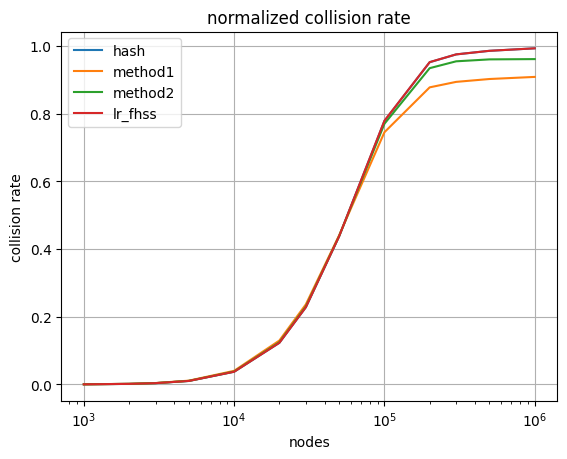

In [97]:
plt.plot(nodes, data[:,0]/totalSlots, label='hash')
plt.plot(nodes, data[:,1]/totalSlots, label='method1')
plt.plot(nodes, data[:,2]/totalSlots, label='method2')
plt.plot(nodes, data[:,3]/totalSlots, label='lr_fhss')
plt.title('normalized collision rate')
plt.xlabel('nodes')
plt.xscale('log')
plt.ylabel('collision rate')
plt.grid()
plt.legend()
plt.show()

#print(f"   hash family; \tsize = {hash_fam.shape[0]}\tHCorrelation = {round(hash_fam_HC,2)}")
#print(f"method1 family; \tsize = {method1_fam.shape[0]}\tHCorrelation = {round(avg_maxHC(method1_fam),2)}")
#print(f"method2 family; \tsize = {method2_fam.shape[0]}\tHCorrelation = {round(avg_maxHC(method2_fam),2)}")
#print(f"lr_fhss family; \tsize = {lr_fhss_family.shape[0]}\tHCorrelation = {round(avg_maxHC(lr_fhss_family),2)}")

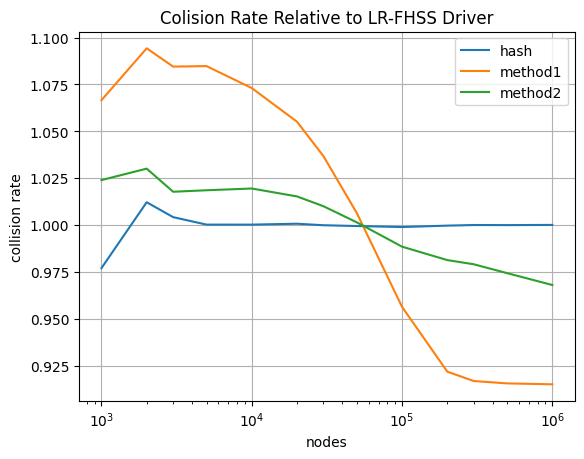

In [98]:
data2 = np.array([data[0,:]/data[0, -1],
                  data[1,:]/data[1, -1], 
                  data[2,:]/data[2, -1], 
                  data[3,:]/data[3, -1], 
                  data[4,:]/data[4, -1], 
                  data[5,:]/data[5, -1], 
                  data[6,:]/data[6, -1],
                  data[7,:]/data[7, -1],
                  data[8,:]/data[8, -1],
                  data[9,:]/data[9, -1],
                  data[10,:]/data[10, -1],
                  data[11,:]/data[11, -1],
                  data[12,:]/data[12, -1]])

plt.plot(nodes, data2[:,0], label='hash')
plt.plot(nodes, data2[:,1], label='method1')
plt.plot(nodes, data2[:,2], label='method2')
#plt.plot(nodes, data2[:,3], label='lr_fhss')
plt.title('Colision Rate Relative to LR-FHSS Driver')
plt.xlabel('nodes')
plt.xscale('log')
plt.ylabel('collision rate')
plt.grid()
plt.legend()
plt.show()

# real lrfhss sequences


In [99]:
import numpy as np

def lr_fhss_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid):
    
    hop = 0
    while 1:

        lsb = lfsr_state & 1
        lfsr_state >>= 1
        if lsb:
            lfsr_state ^= polynomial

        hop = xoring_seed
        if hop != lfsr_state:
            hop ^= lfsr_state

        if hop <= n_grid:
            break

    return lfsr_state, hop - 1

def lfrs_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid):
    
    lsb = lfsr_state & 1
    lfsr_state >>= 1

    if lsb:
        lfsr_state ^= polynomial

    return lfsr_state


# get lr fhss sequence of length 31
def get_lr_fhss_seq(id):
    n_grid = 35
    lr_fhss_lfsr_poly1 = [33, 45, 48, 51, 54, 57]

    lfsr_state = 6
    fhs = []

    polynomial = lr_fhss_lfsr_poly1[id >> 6]
    xoring_seed = id & 0x3F

    for _ in range(31):
        lfsr_state, hop = lr_fhss_get_next_state(lfsr_state, polynomial, xoring_seed, n_grid)
        fhs.append(hop)

    print(f"id={id}\tpoly={polynomial}\tseed={xoring_seed}\nseq = {fhs}\n")

    return fhs

def get_lr_fhss_family():
    fam = []
    for id in range(384):
        fam.append(get_lr_fhss_seq(id))

    return np.array(fam)

In [58]:
lr_fhss_family = get_lr_fhss_family()

id=0	poly=33	seed=0
seq = [2, 31, 15, 7, 3, 1, 0, 32, 30, 22, 20, 25, 12, 24, 28, 26, 21, 10, 17, 8, 27, 13, 6, 33, 16, 29, 14, 18, 19, 9, 4]

id=1	poly=33	seed=1
seq = [1, 32, 16, 8, 4, 2, 0, 31, 29, 21, 19, 26, 11, 23, 27, 25, 22, 9, 18, 7, 28, 14, 5, 34, 15, 30, 13, 17, 20, 10, 3]

id=2	poly=33	seed=2
seq = [0, 33, 17, 9, 5, 1, 2, 34, 28, 20, 22, 23, 14, 26, 30, 24, 19, 8, 15, 10, 29, 11, 4, 31, 18, 27, 12, 16, 21, 7, 6]

id=3	poly=33	seed=3
seq = [2, 34, 18, 10, 6, 0, 1, 33, 27, 19, 21, 24, 13, 25, 29, 23, 20, 7, 16, 9, 30, 12, 3, 32, 17, 28, 11, 15, 22, 8, 5]

id=4	poly=33	seed=4
seq = [6, 19, 11, 3, 5, 4, 26, 18, 16, 29, 8, 34, 28, 24, 30, 17, 14, 31, 21, 12, 32, 23, 9, 2, 20, 25, 10, 33, 22, 15, 13]

id=5	poly=33	seed=5
seq = [5, 20, 12, 0, 6, 3, 25, 17, 15, 30, 7, 33, 27, 23, 29, 18, 13, 32, 22, 11, 31, 24, 10, 1, 19, 26, 9, 34, 21, 16, 14]

id=6	poly=33	seed=6
seq = [4, 21, 13, 1, 3, 6, 24, 16, 18, 27, 10, 32, 30, 26, 28, 15, 12, 33, 19, 14, 34, 25, 7, 0, 22, 23, 8, 31, 20, 17

In [59]:
avg_crossHC(lr_fhss_family)

0.8854780805188243

In [60]:
avg_autoHC(lr_fhss_family)

0.0

In [71]:
avg_maxHC(lr_fhss_family)

3.3441829004329002